# GANs(Generative Adversarial Networks, 적대적 생성신경망)
- GANs란?
- 구현
- tutorials by tensorflow :  https://www.tensorflow.org/beta/tutorials/generative/dcgan

### GANs란?
- GAN은 두 개의 신경망, 즉 생성자(Generator)와 판별자(Discriminator)로 구성된다. 이 두 신경망은 서로 경쟁하면서 훈련되어 서로의 능력치를 상승시켜준다
  - 생성자(Generator): 생성자의 목표는 실제와 같은 데이터를 생성하는 것이다.
  - 판별자(Discriminator): 판별자는 생성자가 생성한 이미지와 실제 이미지를 구별하는 것을 학습한다. 즉, 판별자는 생성된 이미지와 실제 이미지를 구별하여 실제 이미지에 대해 1을 출력하고 생성된 이미지에 대해 0을 출력하도록 훈련된.

#### GANs의 학습 과정
- 판별자 학습: 일반적인 분류기를 학습하는 것과 같다. Generator에서 생성된 Fake데이터와 사전에 수집한 Real 데이터를 각각 판별자에 보낸다. 그 후 예측된 값과 실제 레이블의 오차를 계산하고 역전파 알고리즘을 통해 가중치를 업데이트한다.
  - 결국 Fake와 Real을 잘 판단 할 수 있도록 학습된다.
- 생성자 학습: 생성자는 인풋으로 난수로 생성된 데이터를 받는다. 생성자의 목적은 판별기를 속여 Real데이터라고 속이는것이기 때문에 판별자의 결과를 피드백을 받아 생성자의 가중치들을 학습시킨다.


### Importing the libraries

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
tf.__version__

'2.15.0'

### Loading and pre-processing the dataset
- mnist 데이터를 사용하여 GANs를 구현해본다

In [13]:
# 이미지 분류를 할것이 아니라 그냥 학습데이터만 있어도 충분하다(검 데이터 X)
(x_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()

In [14]:
# shape에 channel에 대한 정보가 없다
x_train.shape

(60000, 28, 28)

In [15]:
y_train.shape

(60000,)

8


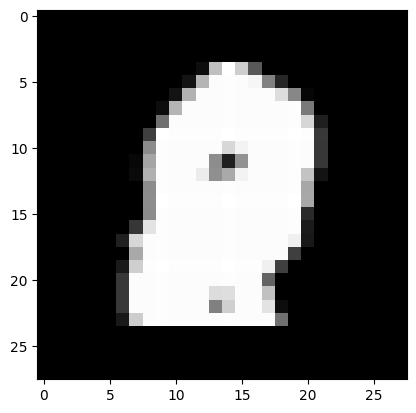

In [16]:
# 데이터 셋에서 임의의 데이터 출력
i=np.random.randint(0,60000)
print(y_train[i])
plt.imshow(x_train[i], cmap='gray');

In [17]:
# 합성곱 신경망에 입력하기 위해 채널을 추가해준다.
# astype으로 정수를 실수로 변환해준다.
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')

In [18]:
x_train.shape

(60000, 28, 28, 1)

In [19]:
x_train[0].min(), x_train[0].max()

(0.0, 255.0)

In [20]:
# 데이터 정규화 -> 0~1이 아닌 -1~1로 정규화한다 -> GANs 개발자가 추천하는 범위(성능 때문)
# x_train = x_train / 255은 0~1 로 정규화되지만 아래 식은 -1~1로 정규화된다.
x_train = (x_train - 127.5)/ 127.5

In [21]:
x_train[0].min(), x_train[0].max()

(-1.0, 1.0)

In [22]:
buffer_size = 60000
batch_size = 256

In [23]:
buffer_size / batch_size

234.375

In [24]:
type(x_train)

numpy.ndarray

In [27]:
# x_train 데이터들을 미니배치 방식으로 데이터셋을 구성한다. -> 복잡한 신경망일 수 록 미니배치가 좋다.
# from_tensor_slices는 넘파이, 리스트 등 다양한 형식을 데이터 셋타입으로 변환
# shuffle은 buffer_size(데이터 개수)만큼 데이터셋의 요소들을 섞는다
# batch는 데이터셋을 batch_size만큼 나누어 관리한다.(234개의 데이터셋)
x_train = tf.data.Dataset.from_tensor_slices(x_train).shuffle(buffer_size).batch(batch_size)

In [28]:
type(x_train) # BatchDataset 타입으로 신경망에 한번에 학습 시킬 이미지를 모아둔 type이다. (tensorflow 변수)

tensorflow.python.data.ops.batch_op._BatchDataset

In [29]:
# shape의 None은 배치당 가지고있는 이미지의 개수이다.(배치마다 다를 수 있어서 None으로 표기 -> 가변적인 데이터 포인트 개)
x_train

<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

### Building the generator
- Batch normalization: https://keras.io/api/layers/normalization_layers/batch_normalization/
- Leaky Relu: https://keras.io/api/layers/activation_layers/leaky_relu/
- Activation functions: https://medium.com/@himanshuxd/activation-functions-sigmoid-relu-leaky-relu-and-softmax-basics-for-neural-networks-and-deep-8d9c70eed91e
- Padding: https://www.pico.net/kb/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-tensorflow